In [1]:
import torch
import taichi as ti
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import src.Simulation as Simulation
import src.physics as physics
import importlib
importlib.reload(Simulation)
importlib.reload(physics)

[Taichi] version 1.7.0, llvm 15.0.7, commit 6b563a2a, osx, python 3.10.8


[I 10/21/23 19:26:10.558 10783467] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


<module 'src.physics' from '/Users/aidanbx/CS/EINCASM/src/physics.py'>

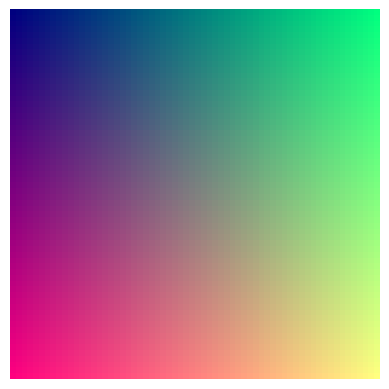

In [2]:

# Taichi
image_height = 256
image_width = 256
ph = 5
pw = 5
tile_height = 64
tile_width = 64
shift_x = ti.Vector([32, 32])
shift_y = ti.Vector([32, 32])

# Create gradients for R, G, B channels
r_gradient = torch.linspace(0, 1, tile_height).view(tile_height, 1).expand(tile_height, tile_width)
g_gradient = torch.linspace(0, 1, tile_width).view(1, tile_width).expand(tile_height, tile_width)
b_gradient = torch.ones_like(r_gradient) * 0.5  # Constant blue for demonstration, you can set your gradient here

# Combine the R, G, B channels
tile = torch.stack([r_gradient, g_gradient, b_gradient], dim=2)
tile = torch.stack([r_gradient, g_gradient, b_gradient], dim=2)

image_pixels = torch.zeros(image_height, image_width, 3, dtype=torch.float32)
# Assuming tile is already defined as above
plt.imshow(tile.numpy())
plt.axis('off')
plt.show()

In [59]:
celltype = ti.types.struct(
    a = ti.Vector.field(2, dtype=ti.f32),
    x = ti.f32,
)
c = celltype(ti.Vector.field([2,2], dtype=ti.f32))
c.keys()

tensor([0.0317, 0.0317, 0.5000])

In [ ]:
ti.Vector.field([2,2], dtype=ti.f32)

In [16]:
def share_memory(tensor1, tensor2):
    return tensor1.storage().data_ptr() == tensor2.storage().data_ptr() and \
            tensor1.storage_offset() == tensor2.storage_offset() and \
            tensor1.stride() == tensor2.stride() and \
            tensor1.size() == tensor2.size()

# Example usage
a = torch.tensor([, 3, 4])
b = a[::2]
c = a.clone()

print(share_memory(a, b))  # Should return True, as 'b' is a view of 'a'
print(share_memory(a, c))  # Should return False, as 'c' is a clone of 'a'
print(a.data_ptr(), b.data_ptr(), c.data_ptr())  # Should return the same memory address for 'a' and 'b', but a different one for 'c'
print(a.storage().data_ptr(), b.storage().data_ptr(), c.storage().data_ptr())  # Should return the same memory address for 'a' and 'b', but a different one for 'c'

False
False
5791569536 5791569536 4620940608
5791569536 5791569536 4620940608


In [31]:
torch.zeros(10, 2, 2).shape

torch.Size([10, 2, 2])

In [39]:
sim = Simulation.Simulation()
def init_a(shp, md):
    a = torch.zeros(shp)
    return a, {}
sim.add_channel('a', init_a, num_layers=10)

sim.add_subchannel('b', 'a', indices=[0, 1])
sim.add_subchannel('c', 'a', indices=[2])


sim.add_rule('noise', physics.random_noise,
             input_channel_ids=[],
             affected_channel_ids=['b', 'c'])

sim.init_all_channels()

sim.apply_rule('noise')
sim.channels['c']

(10, 100, 100)


subChannel(
	id=c,
	shape=(1, 100, 100),
	dtype=torch.float32,
	device=cpu,
	initialized=True,
	contents=
[[[0.5110973119735718, 0.7062475681304932,
   -0.196150541305542, -0.4894977807998657,
   -0.4059032201766968, -0.20153307914733887,
   -0.3329356908798218, 0.6616822481155396,
   -0.3426706790924072, 0.15167641639709473,
   0.5123602151870728, 0.7828843593597412,
   -0.2574338912963867, 0.7057311534881592,
   0.2259981632232666, 0.05829489231109619,
   -0.2617471218109131, 0.8577392101287842,
   -0.4201476573944092, -0.603217363357544,
   -0.6859283447265625, 0.16447651386260986,
   0.47420454025268555, -0.681878924369812,
   0.5212138891220093, 0.6567721366882324,
   -0.6264920234680176, -0.2867100238800049,
   0.5704700946807861, -0.6172016859054565,
   -0.6445910930633545, 0.5552091598510742,
   -0.011497020721435547, 0.8032017946243286,
   -0.4979097843170166, -0.5787191390991211,
   -0.04943382740020752, 0.9008057117462158,
   0.04962623119354248, 0.2447136640548706,
   0.843

In [11]:
big_tensor = torch.rand(100, 100)
print("Original memory address of big tensor:", id(big_tensor))

small_tensor_1 = big_tensor[:50, :50]
print("Memory address of small tensor 1:", id(small_tensor_1))
small_tensor_1.data = torch.rand(50, 50)
print("Memory address of small tensor 1 after updating data:", id(small_tensor_1))

small_tensor_2 = big_tensor[50:, 50:]
print("Memory address of small tensor 2:", id(small_tensor_2))
small_tensor_2.data = torch.rand(50, 50)
print("Memory address of small tensor 2 after updating data:", id(small_tensor_2))


Original memory address of big tensor: 5810182304
Memory address of small tensor 1: 5810182384
Memory address of small tensor 1 after updating data: 5810182384
Memory address of small tensor 2: 4383372080
Memory address of small tensor 2 after updating data: 4383372080


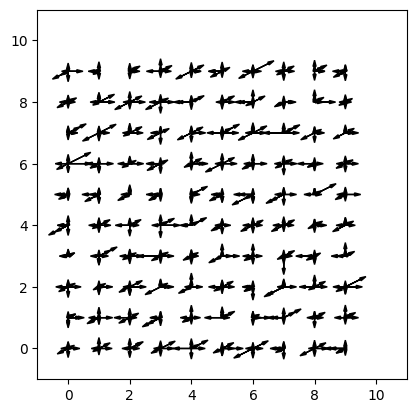

In [10]:
# Sample kernel and muscles tensor
kernel = torch.tensor([
    [0, 0],
    [-1, 0],
    [1, 1],
    [0, 1.0],
    [1, 0],
    [-1, -1],
    [0, -1]
], dtype=torch.float32)

w, h = 10, 10  # Grid dimensions
muscles = torch.randn((kernel.shape[0], w, h)) * 0.2  # Random sample muscles tensor

# Set up matplotlib figure
fig, ax = plt.subplots()
ax.set_aspect('equal', adjustable='box')

for x in range(w):
    for y in range(h):
        for k in range(kernel.shape[0]):
            dx, dy = kernel[k]
            magnitude = muscles[k, x, y]
            ax.arrow(x, y, dx * magnitude, dy * magnitude*0.5, head_width=0.1, head_length=0.2, fc='k', ec='k')

# Set axis limits and show the plot
ax.set_xlim(-1, w+1)
ax.set_ylim(-1, h+1)
plt.show()


In [3]:

# HEX
kernel = torch.tensor([
    [0, 0],     # ORIGIN
    [-1, 0],    # N
    [1, 1],     # NW
    [0, 1.0],   # W
    [1, 0],     # S
    [-1, -1],   # SE
    [0, -1]     # E
], dtype=torch.int8)

sim = Simulation.Simulation(world_shape=(2,2))

sim.add_channel('capital')
sim.add_channel('muscles', num_layers=kernel.shape[0], metadata={'kernel': kernel})
sim.add_channel('deltas', num_layers=kernel.shape[0])

def add_random(sim, cap, musc, deltas, md):
    musc.contents += torch.rand(musc.contents.shape) + 0.1

sim.add_rule('grow', add_random,
             input_channel_ids=['capital','muscles','deltas'],
             affected_channel_ids=['muscles', 'capital'],
             metadata={'growth_cost': 0.1,})

sim.init_all_channels()

In [17]:
tensor1 = torch.rand((5, 10, 10))
tensor2 = torch.rand((1, 10, 10))
tensor1 *= tensor2


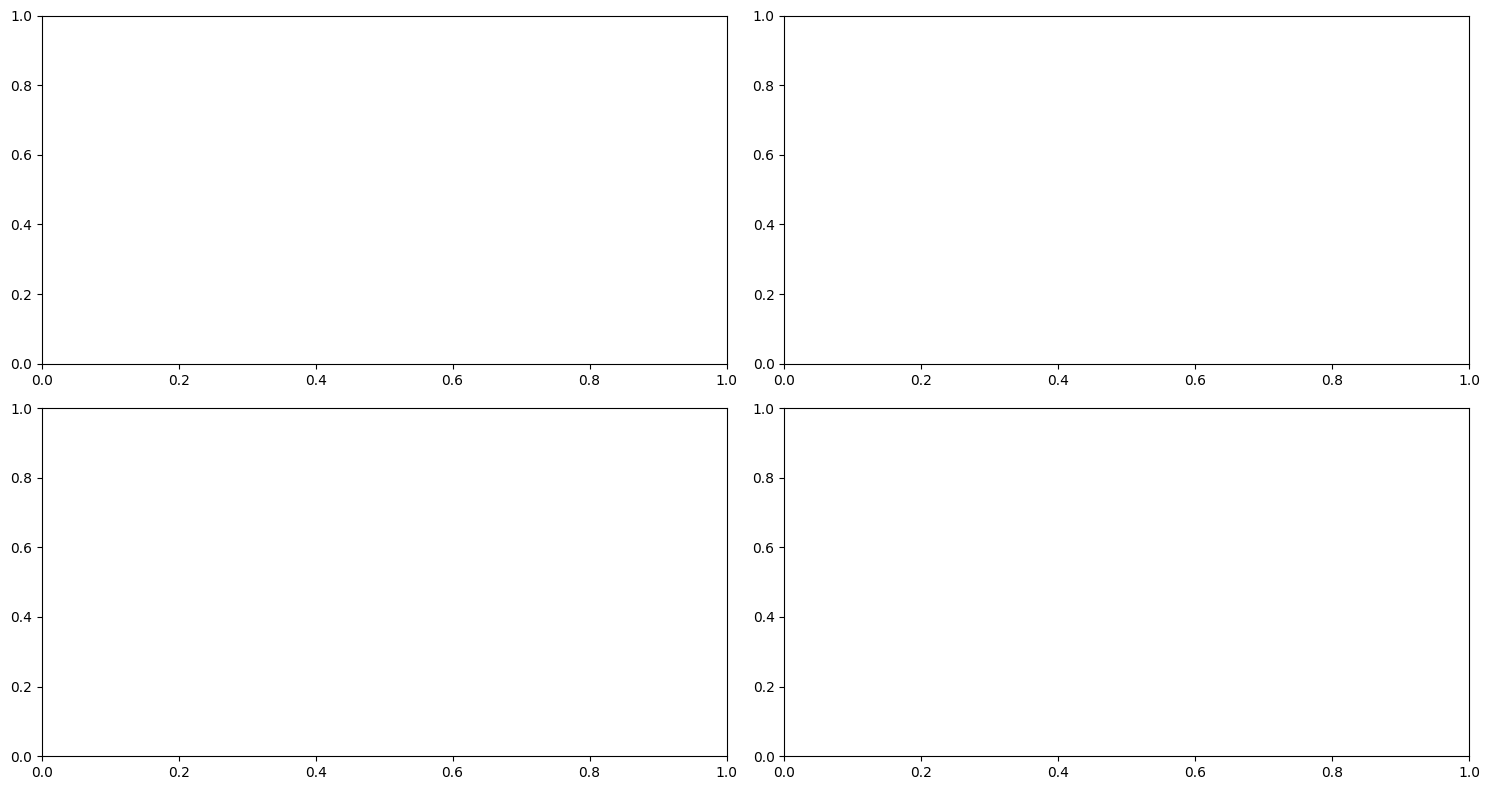

In [14]:

fig = plt.figure(figsize=(15, 8))
gs = gridspec.GridSpec(2, 2, height_ratios=[1,1])
ax_tl = fig.add_subplot(gs[0, 0])
ax_tr = fig.add_subplot(gs[0, 1])
ax_bl = fig.add_subplot(gs[1, 0])
ax_br = fig.add_subplot(gs[1, 1])

def update(frame):
    sim.apply_rule('grow')
    for x in range(w):
        for y in range(h):
            for k in range(kernel.shape[0]):
                dx, dy = kernel[k]
                magnitude = muscles[k, x, y]
                ax_br.arrow(x, y, dx * magnitude, dy * magnitude*0.5, head_width=0.1, head_length=0.2, fc='k', ec='k')

ani = FuncAnimation(fig, update, frames=100, interval=50, repeat=True)
plt.tight_layout()
plt.show()

In [1]:
import src.pcg as pcg
pcg.init_obstacles_perlin((1,100,100), {})[0].shape

torch.Size([1, 100, 100])

In [281]:
import os
import torch

base_folder = "runs/"
stamp = "20231005-0443-1"
folder = os.path.join(base_folder, stamp)
data = []
for i in range(100):
    path = os.path.join(folder, f"{i}.pt")
    if os.path.exists(path):
       data.append(torch.load(path))

In [282]:
import importlib
import src.EINCASM as EINCASM
importlib.reload(EINCASM)

ein = EINCASM.EINCASM("config.yaml")
ein.sim.init_all_channels()
ein.sim.update()

TypeError: 'module' object is not callable

In [ ]:
ein.sim.update()
ein.sim.metadata


{'id': 'EINCASM Experiment', 'world_shape': (100, 100), 'period': 46.0}

In [378]:
import torch

channels = {
    't1': (torch.randn(1, 1, 1)**2).to(torch.int),
    't2': (torch.randn(2, 1, 1)**2).to(torch.int),
    't3': (torch.randn(3, 1, 1)**2).to(torch.int),
    'tsafe': (torch.randn(1, 1, 1)**2).to(torch.int),
}

def define_group(group_id, channel_ids, isgroup={
    't1': False,
    't2': False,
    't3': False,
    'tsafe': False,
    'Group_t1t2': True,
    'Group_t2t3': True,
    'Group_g1t1': True,
}):
    # Create a list of the selected tensors
    selected_tensors = [channels[ch_id] for ch_id in channel_ids]
    
    # Stack the tensors to create the group tensor
    group_tensor = torch.cat(selected_tensors, dim=0)    

    # Add the group tensor to the channels dictionary
    channels[group_id] = group_tensor
    
    # Update the channels dictionary with views from the group tensor
    start_idx = 0
    for ch_id in channel_ids:
        if isgroup[ch_id]:
            
        end_idx = start_idx + channels[ch_id].shape[0]
        channels[ch_id] = group_tensor[start_idx:end_idx].view(channels[ch_id].shape)
        start_idx = end_idx

# Test Case 1: Two groups sharing a channel
define_group('Group_t1t2', ['t1', 't2'])
define_group('Group_t2t3', ['t2', 't3'])

# Test Case 2: Groups of groups
define_group('Group_g1t1', ['Group_t1t2', 't1'])

channels['Group_g1t1'][-1, 0, 0] = 999
channels

{'t1': tensor([[[999]]], dtype=torch.int32),
 't2': tensor([[[0]],
 
         [[0]]], dtype=torch.int32),
 't3': tensor([[[0]],
 
         [[1]],
 
         [[0]]], dtype=torch.int32),
 'tsafe': tensor([[[0]]], dtype=torch.int32),
 'Group_t1t2': tensor([[[0]],
 
         [[0]],
 
         [[0]]], dtype=torch.int32),
 'Group_t2t3': tensor([[[0]],
 
         [[0]],
 
         [[0]],
 
         [[1]],
 
         [[0]]], dtype=torch.int32),
 'Group_g1t1': tensor([[[  0]],
 
         [[  0]],
 
         [[  0]],
 
         [[999]]], dtype=torch.int32)}

In [571]:
t1 = torch.randn(5, 2, 2)
a = t1[0]
b = t1[1]
c = t1[2]
d = t1[3]

g1 = t1[:2]
g2 = t1[1:3]

g1[0, 0, 0] = 999

a.data_ptr() == g1[0].data_ptr()


True

In [590]:
print(torch.mps.current_allocated_memory())
a = torch.randn(10, 1000, 1000, device='mps:0')
print(torch.mps.current_allocated_memory())
b = a[0]
c = a[1]
d = a[2]
print(torch.mps.current_allocated_memory())
del a, b, c, d
torch.mps.empty_cache()
print(torch.mps.current_allocated_memory())


22463488
62463488
62463488
22463488


In [36]:
import importlib
import src.Simulation as Simulation
importlib.reload(Simulation)
import src.Channel as Channel
importlib.reload(Channel)

sim = Simulation.Simulation(world_shape=(2,2))
sim.add_channel('t1', num_layers=3)

sim.add_subchannel('t1_1', 't1', indices=[0, 1])

sim.init_all_channels()

for ch in sim.channels.values():

AttributeError: 'Channel' object has no attribute 'data_ptr'